## HW \#3: Motion Planning with RRT and Variants
<p style="position: relative; top:-20px; margin: 0px; padding 0px; font-size: 12px">(C) 2023 Bradley Hayes and Christoffer Heckman, University of Colorado Boulder</p>
<p style="position: relative; top:-20px; margin: 0px; padding 0px; font-size: 4px">v1.0</p>

**Deliverable**: A completed Jupyter notebook in both ipynb and PDF format, uploaded to Canvas along with the generated images from your code execution (automatically saved in the same folder). The starter code will generate the necessary images, please do not modify any code that visualizes results.

**Graduate Students**: Please complete the entire assignment.

**Undergraduate Students**: Please complete questions that do not have **(GRAD)** next to them. (You may attempt these for extra credit)

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import hw3_rrt
from hw3_rrt import Node

In [2]:
name="Aniket Anbhule" # TODO: Replace with your name
print("Name: " + name)
GRAD = None # TODO: set to True if Graduate Student, False otherwise

Name: Aniket Anbhule


In [3]:
%pip install numpy matplotlib
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


RRT and its variants produce a graph that approximates a continuous space, typically for the purpose of motion planning in high dimensional domains where complete (and optimal) methods fail. Adding difficulty to this problem is the fact that it is rare for our robot platforms to be holonomic, meaning that their mechanical degrees of freedom completely cover the degrees of freedom of the environment they operate in and the order of motor actuations does not have an impact on final position. For this reason, it is common to use sampling-based algorithms like those in the RRT family in two ways:
  
  
1. Waypoints: Assuming a holonomic robot, use RRT to provide a sequence of intermediate environment position goals for the robot on the way to the goal state, which the robot will reach by employing a separate controller (e.g., assume holonomic with the use of a PID controller or other local planner)

2. Direct Control: Compute a sequence of control inputs directly using the RRT algorithm, by using a **model** of the robot to ensure each edge represents a feasible state transition that the robot can execute.

### [5 pts undergraduate, 2 pts graduate] Rapidly-Exploring Random Trees 
First, you will implement the RRT algorithm. We will put this code in the aptly named function ```rrt```. Before we jump into the main algorithm, we need to add code to implement the general-purpose ```get_nearest_vertex``` and ```steer_holonomic``` functions (any valid implementation will do). Within your ```rrt``` implementation, a function named ```steer``` is passed in that you will use for the algorithm. Our test scripts will automatically populate this with the appropriate steer function you've implemented, as you will implement both a holonomic version here and a more complex version further on.

Make use of the provided ```Node``` class, with the following built-in functions:  
   Constructor: ```Node(point: np.ndarray, parent: Node=None)```  
   Member Variables:
   - ```point``` (np.ndarray) -- The point in state space represented by this Node object
   - ```parent``` (Node) -- The Preceeding Node that this Node connects to
   - ```path_from_parent``` (np.ndarray) -- List of points indicating a valid path from the parent node's point to this node's point.
    
***Points will be deducted for solutions that do not generalize to n-dimensional state spaces***  
(treat points as vectors, not as x,y coordinates e.g., (point[0], point[1]))

In [3]:
def get_nearest_vertex(node_list: list[Node], q_point: np.ndarray) -> Node:

	# TODO: Your code here
	# HINT: np.linalg.norm will return the length of a vector	
   
    nearest_vertex = None
    min_distance = np.inf
    
    for node in node_list:
        dist = np.linalg.norm(node.point - q_point)
        if dist < min_distance:
            min_distance = dist
            nearest_vertex = node
            
    return nearest_vertex

	'''
	@param node_list: List of Node objects
	@param q_point: Query point, a numpy array of appropriate dimension
	@return Node in node_list with the closest node.point to the query q_point
	'''

In [4]:
def steer_holonomic(from_point: np.ndarray, to_point: np.ndarray, delta_q: float) -> np.ndarray:

    # TODO: Use a path discretization resolution of 10 steps for computing a path between points
    #       (path[0] should be the starting point and path[-1] should be the endpoint of the path)
    # Hint: np.linspace may be useful here    
    
    vector = to_point - from_point
    distance = np.linalg.norm(vector)
    
    if distance > delta_q:
        vector *= (delta_q/distance)
    
    new_point = from_point + vector
    path = np.linspace(from_point, new_point, num = 10)

    return path

'''
    @param from_point: Point where the path to "to_point" is originating from
    @param to_point: Point indicating destination
    @param delta_q: Max path-length to cover
    @returns path: list of points leading from "from_point" to "to_point" (inclusive of endpoints)
    '''

In [5]:
def rrt(state_bounds: np.ndarray, state_is_valid: Callable[[np.ndarray],bool], starting_point: np.ndarray, goal_point: np.ndarray, steer: Callable[[np.ndarray, np.ndarray, float], np.ndarray], k: int, delta_q: float) -> list[Node]:

    node_list = []
    node_list.append(Node(starting_point))

    # Your code here. Please use the Node class each vertex in your tree.
    
    for i in range(k):
        rand = np.random.uniform(state_bounds[:,0], state_bounds[:,1], size=(state_bounds.shape[0]))
        nearest_node = get_nearest_vertex(node_list, rand)
        path = steer(nearest_node.point, rand, delta_q)
        
        free = True
        for p in path:
            if not state_is_valid(p):
                free = False
        if free:
            new_node = Node(path[-1])
            new_node.parent = nearest_node
            new_node.path_from_parent = path.tolist()
            node_list.append(new_node)
            
            if goal_point is not None and np.linalg.norm(goal_point - new_node.point) < delta_q:
                goal_node = Node(goal_point)
                goal_node.parent = nearest_node
                goal_node.path_from_parent = path.tolist()
                node_list.append(goal_node)
                return node_list

    return node_list

'''
    Implement the RRT algorithm here, making use of the provided function state_is_valid(np.ndarray) -> bool. 
    If goal_point is set, your implementation should return once a path to the goal has been found, 
    using k as an upper-bound. Otherwise, it should build a graph without a goal and terminate after k
    iterations. [NB: Make sure your paths between vertices are valid before adding them!]

    @param state_bounds: matrix of min/max values for each dimension (e.g., [[0,1],[0,1]] for a 2D 1m by 1m square)
    @param state_is_valid: function that maps states (N-dimensional Real vectors) to a Boolean (indicating free vs. forbidden space)
    @param starting_point: Point within state_bounds to grow the RRT from
    @param goal_point: Point within state_bounds to target with the RRT. (OPTIONAL, can be None)
    @param steer: Function steer(from_point, to_point, delta_q) that returns a valid path from from_point to to_point subject to delta_q.
    @param k: Number of points to sample
    @param delta_q: Maximum distance allowed between vertices
    @returns List of RRT graph nodes
    '''

#### Test Your RRT (no goal) implementation and visualize your graph by running the cells below!

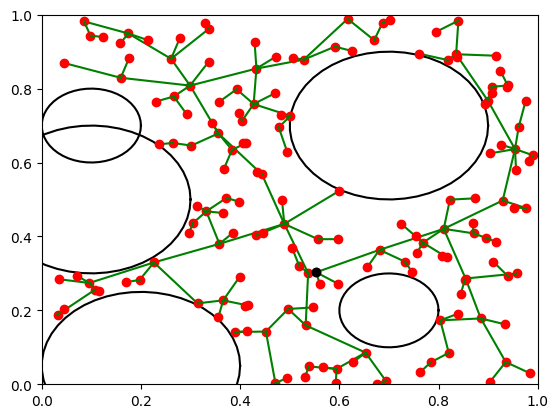

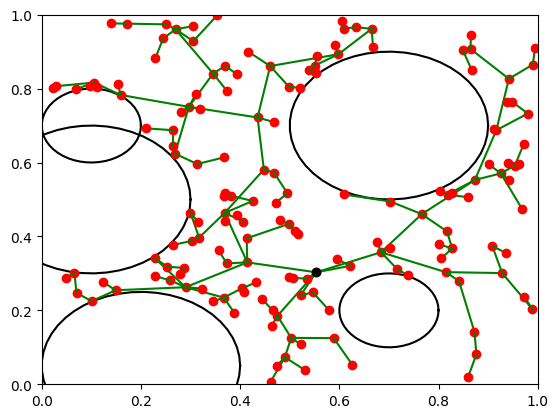

In [6]:
hw3_rrt.test_static_rrt_no_goal([rrt, rrt], steer_holonomic, '01')

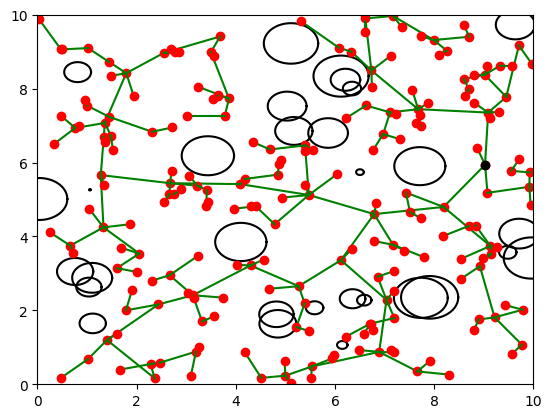

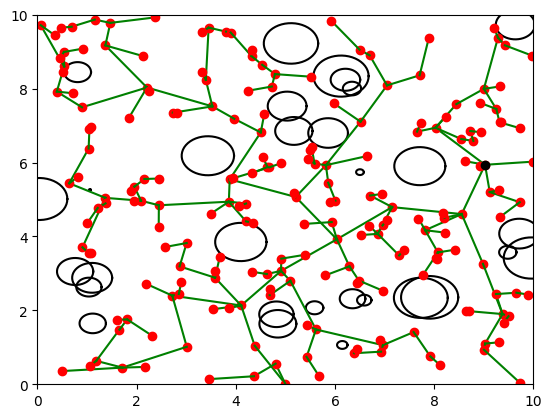

In [7]:
hw3_rrt.test_random_rrt([rrt, rrt], steer_holonomic, '02')

#### Test your goal-directed RRT by running the cells below!

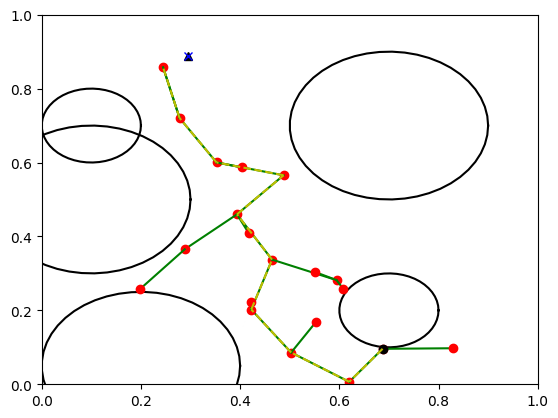

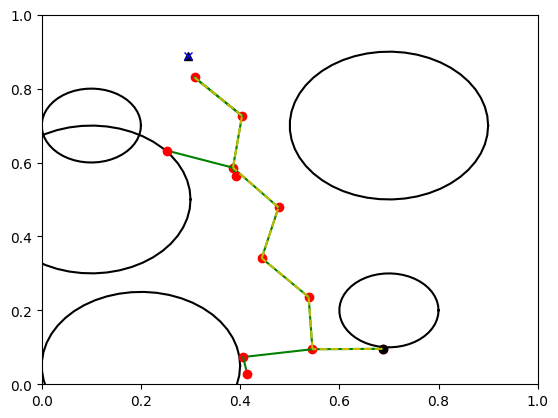

In [8]:
hw3_rrt.test_static_rrt_goal([rrt, rrt], steer_holonomic, '03')

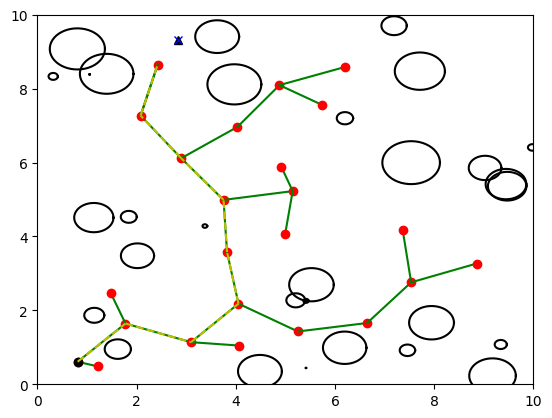

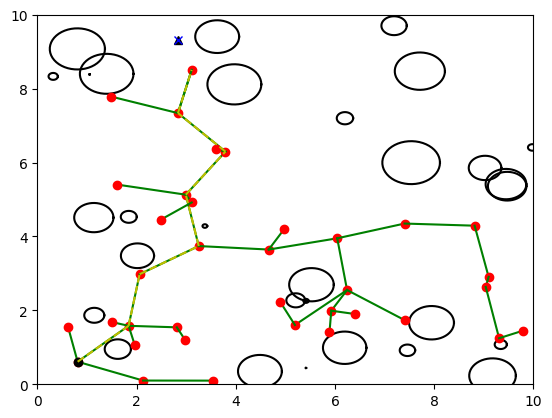

In [9]:
hw3_rrt.test_random_rrt_goal([rrt, rrt], steer_holonomic, '04')

### [5 pts undergraduate, 4 pts graduate] RRT*
Next, you will implement the RRT* algorithm. We will put this code in the function ```rrt_star```. Before we jump into the main algorithm, we need to add code to implement the general-purpose ```get_nearest_vertex``` and ```steer_holonomic``` functions (any valid implementation will do).

Make use of the provided ```Node``` class, with the following built-in functions:  
   Constructor: ```Node(point: np.ndarray, parent: Node=None)```  
   Member Variables:
   - ```point``` (np.ndarray) # The point in state space represented by this Node object
   - ```parent``` (Node) # The Preceeding Node that this Node connects to
   - ```path_from_parent``` (np.ndarray) # List of points indicating a valid path from the parent node's point to this node's point.

'''
    TODO: Implement the RRT* algorithm here, making use of the provided state_is_valid and steer functions

    @param state_bounds: matrix of min/max values for each dimension (e.g., [[0,1],[0,1]] for a 2D 1m by 1m square)
    @param state_is_valid: function that maps states (N-dimensional Real vectors) to a Boolean (indicating free vs. forbidden space)
    @param k: Number of points to sample
    @param delta_q: Maximum distance allowed between vertices
    @returns List of RRT* graph nodes
    '''

In [10]:
def clearance(path: np.ndarray, state_is_valid: Callable[[np.ndarray],bool]): #function to validate path from steer holonomic
    
    clearance = 0
    c_count = 0
    
    while (c_count < len(path) ):
        
        if ( state_is_valid( path[c_count] ) == True ):
            clearance = clearance + 1
        c_count = c_count + 1
        
    if ( clearance == len(path) ):
        return True
    return False

def distance(to_point: np.ndarray, from_point: np.ndarray):
    vector = to_point - from_point
    dist = np.linalg.norm(vector)
    
    return dist

def costs(node_list: list[Node], to_node: Node):

    cost = 0 
    
    lis = to_node
    while(1):
        if( lis.parent is None):
            break
        lis_parent = lis.parent
        cost = cost + distance( lis.point , lis_parent.point )
        lis = lis_parent
            
    return cost

In [11]:
def rrt_star(state_bounds, state_is_valid, starting_point, goal_point, steer, k, delta_q):
    node_list = []
    root = Node(starting_point)
    node_list.append(root)

    count = 0

    for i in range(k):
        rand = np.random.uniform(state_bounds[:, 0], state_bounds[:, 1], size=state_bounds.shape[0])
        nearest_node = get_nearest_vertex(node_list, rand)
        path = steer(nearest_node.point, rand, delta_q)

        clearance = sum([state_is_valid(p) for p in path])

        if clearance != len(path):
            continue

        new_list = [n for n in node_list if delta_q >= distance(path[-1], n.point)]

        c_min = np.inf
        min_node_cost = None
        path_min_cost = None

        for n in new_list:
            new_path = steer(n.point, path[-1], delta_q)

            if sum([state_is_valid(p) for p in new_path]) != len(new_path):
                continue

            cost = costs(node_list, n) + distance(path[-1], n.point)

            if cost < c_min:
                c_min = cost
                min_node_cost = n
                path_min_cost = new_path

        new_node = Node(path[-1], min_node_cost)
        new_node.path_from_parent = path_min_cost

        node_list.append(new_node)
        count += 1

        for n in new_list:
            new_path = steer(n.point, path[-1], delta_q)

            if sum([state_is_valid(p) for p in new_path]) != len(new_path):
                continue

            neighbor_cost = costs(node_list, n)
            c_new = costs(node_list, new_node) + distance(path[-1], n.point)

            if c_new < neighbor_cost:
                node_number = node_list.index(n)
                node_list[node_number].parent = new_node
                node_list[node_number].path_from_parent = steer(new_node.point, n.point, delta_q)

    if goal_point is not None:
        new_node = get_nearest_vertex(node_list, goal_point)
        path = steer(new_node.point, goal_point, delta_q)

        goal_node = Node(goal_point, new_node)
        goal_node.path_from_parent = path
        node_list.append(goal_node)

    return node_list

    



#### Verify your implementation of RRT* by running the tests below:

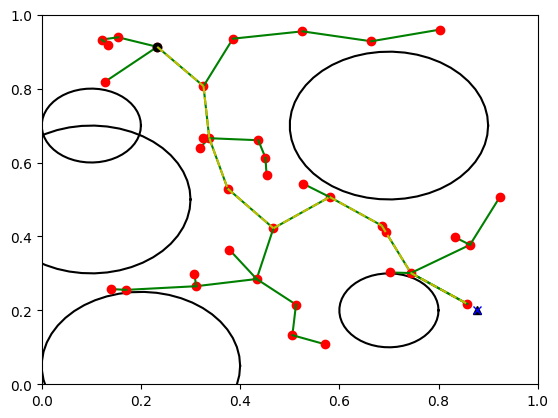

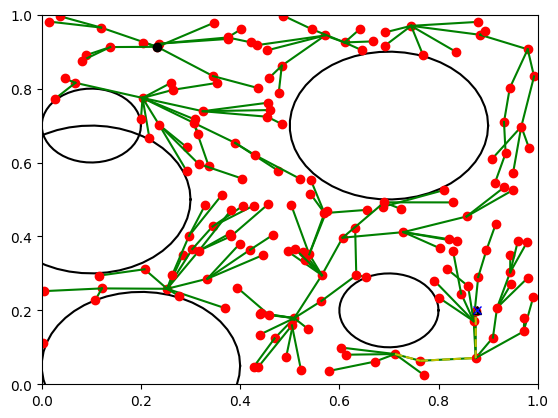

In [12]:
hw3_rrt.test_static_rrt_goal([rrt, rrt_star], steer_holonomic, '05')

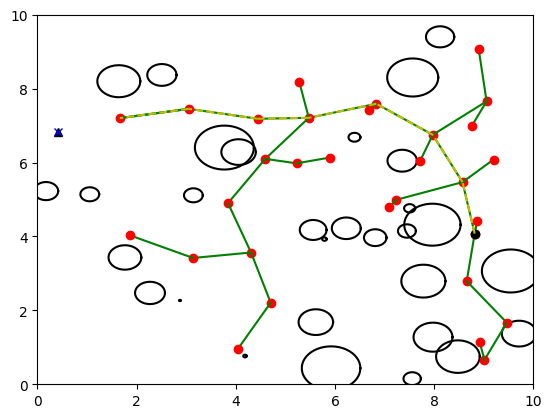

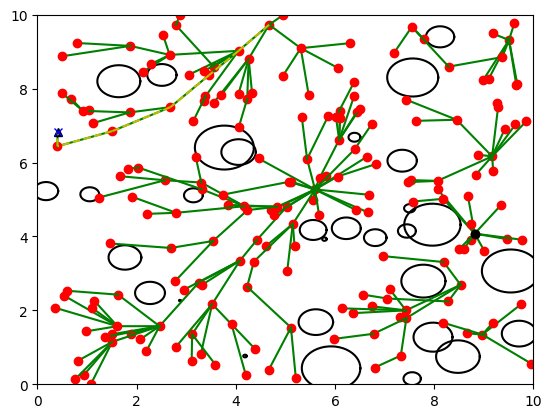

In [13]:
hw3_rrt.test_random_rrt_goal([rrt, rrt_star], steer_holonomic, '06')

### [+2pts Undergraduate, 4pts Graduate] Non-Holonomic RRT (GRAD)
If our robot cannot freely traverse the coordinate system used in our RRT algorithm, then we can't just add vertices wherever we want and interpolate from existing ones (our robot may not be able to take a straight-line path or even get to the new vertex!). Fill in the code for the ```initialize_non_holonomic_actions``` and ```steer_discrete_non_holonomic``` functions implementing a Reeds-Shepp-inspired car model with a discrete action space given as a list ```actions_list```. 

Your vehicle model should support at least six actions: {turn left, drive straight, turn right} for both the forwards and backwards direction. Your vehicle can maintain a maximum steering angle of +/- 60 degrees with speed no greater than 0.25. Each of these actions is to be represented by a tuple (speed, steering angle) that will be executed over a single, universal timestep each. Your vehicle's steering angle should always be kept within the range of [-pi,pi]

In [14]:
def initialize_non_holonomic_actions() -> np.ndarray:
    max_steering_angle = np.pi/3
    max_speed = 0.25
    
    # Define the action tuples for turning left, driving straight, and turning right
    turn_left_forward = (max_speed, max_steering_angle)
    drive_straight_forward = (max_speed, 0)
    turn_right_forward = (max_speed, -max_steering_angle)
    
    # Define the action tuples for turning left, driving straight, and turning right in reverse
    turn_left_reverse = (-max_speed, -max_steering_angle)
    drive_straight_reverse = (-max_speed, 0)
    turn_right_reverse = (-max_speed, max_steering_angle)
    
    actions = np.array([
        turn_left_forward,
        drive_straight_forward,
        turn_right_forward,
        turn_left_reverse,
        drive_straight_reverse,
        turn_right_reverse
    ])

    action_list = list(actions)

    return action_list

In [32]:
def simulate_non_holonomic_action(start_point: np.ndarray, action: np.ndarray) -> np.ndarray:
    '''
    Returns a discretized path along which the agent moves when performing an action from a given point.    
    @param start_point: A 3-dimensional vector encoding the starting [x,y,theta] of the robot
    @returns path: A list of 3-dimensional points beginning at "start_point" and ending the appropriate distance away
    '''
    x, y, theta = start_point
    
    # Unpack action into speed and steering angle
    speed, steering_angle = action
    
    # Ensure the steering angle is within [-pi, pi]
    steering_angle = np.clip(steering_angle, -np.pi, np.pi)
    
    # Calculate the turning radius
    if steering_angle == 0:
        turning_radius = np.inf
    else:
        turning_radius = speed / steering_angle
        
    # Calculate the distance traveled
    distance_traveled = speed * 1.0 # 1.0 time step
    
    # Calculate the arc length and angle turned
    if turning_radius == np.inf:
        arc_length = distance_traveled
        angle_turned = 0
    else:
        arc_length = 2 * np.pi * abs(turning_radius) * abs(steering_angle) / (2 * np.pi)
        angle_turned = distance_traveled / arc_length * steering_angle
    
    # Calculate the new x, y, and theta values
    if turning_radius == np.inf:
        new_x = x + distance_traveled * np.cos(theta)
        new_y = y + distance_traveled * np.sin(theta)
        new_theta = theta
    else:
        new_x = x + turning_radius * (np.sin(theta + angle_turned) - np.sin(theta))
        new_y = y - turning_radius * (np.cos(theta + angle_turned) - np.cos(theta))
        new_theta = theta + angle_turned
    
    # Pack the new x, y, and theta values into a 3-dimensional vector
    new_point = np.array([new_x, new_y, new_theta])
    
    # Construct the path by linearly interpolating between the starting point and the end point
    path = np.linspace(start_point, new_point, num=10)
    
    return path

In [33]:
def steer_non_holonomic(from_point: np.ndarray, to_point: np.ndarray, delta_q: float) -> np.ndarray:
    '''
    Given a fixed discrete action space from initialize_non_holonomic_actions and robot model from simulate_non_holonomic_action, 
    choose the action that gets you closest to "to_point" when executing it from "from_point"

    @param from_point: (x,y,theta) vector where the path to "to_point" is originating from
    @param to_point: (x,y,theta) vector indicating desired destination
    @param delta_q: Maximum allowable path length. Truncate your path if its length exceeds delta_q.
    @returns path: list of (x,y,theta) vectors leading from "from_node" to "to_point" (inclusive of endpoints)
    '''
    # Our discrete non-holonomic action space will consist of a limited set of movement primitives.
    # Your code should choose an action from the actions_list and apply it for this implementation
    # of steer. You can simulate an action with simulate_non_holonomic_action
    # which will give you a list of points along the path the agent travels, starting at start_point. 
    # Index -1 (the last element) of the resulting path is where the agent ends up after that action ends.
    
    #actions_list = initialize_non_holonomic_actions()
    
    # Hint: Use simulate_non_holonomic_action(state, action) to test actions before choosing one
    
    path = []

    actions_list = initialize_non_holonomic_actions()

    min_distance = np.inf
    best_path = None

    for action in actions_list:
        path = simulate_non_holonomic_action(from_point, action)
        end_point = path[-1]

        distance = np.linalg.norm(end_point - to_point)

        if distance < min_distance:
            min_distance = distance
            best_path = path

    if len(best_path) > delta_q:
        best_path = best_path[:10]

    return best_path

    

#### Test your non-holonomic RRT implementation of a Reeds-Shepp car by running the tests below:

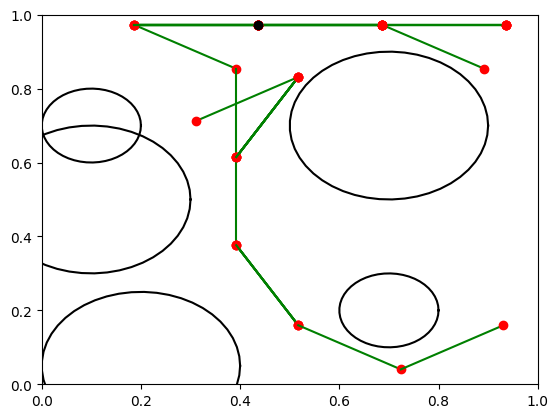

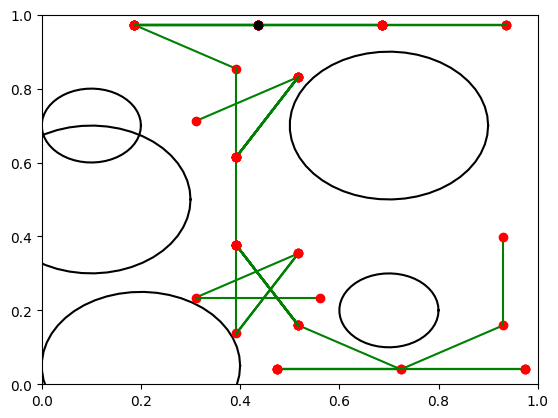

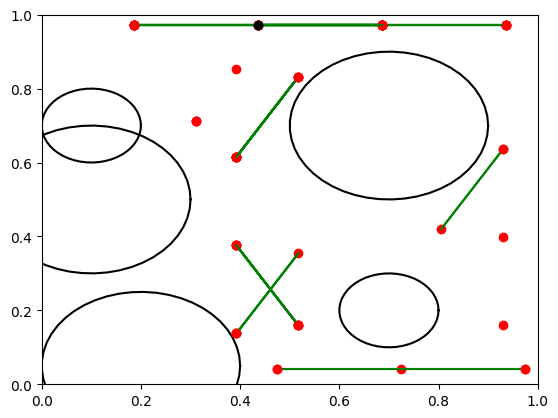

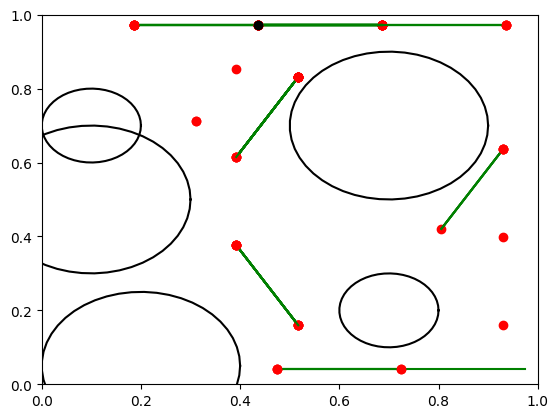

In [34]:
hw3_rrt.test_non_holonomic_rrt([rrt, rrt, rrt_star, rrt_star], steer_non_holonomic, '07')

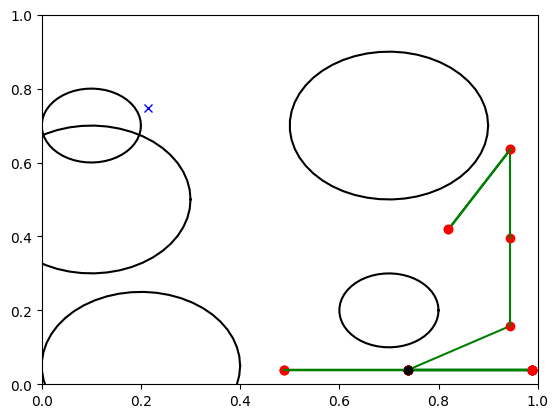

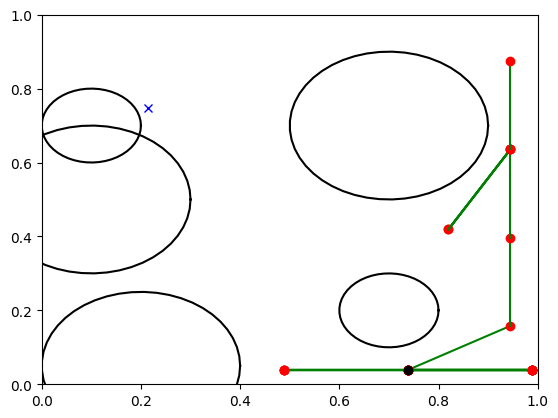

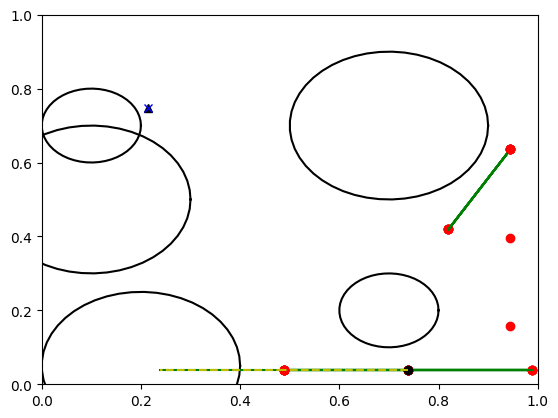

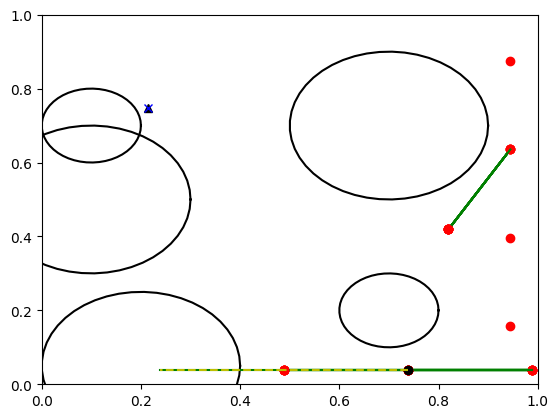

In [35]:
hw3_rrt.test_non_holonomic_rrt_goal([rrt, rrt, rrt_star, rrt_star], steer_non_holonomic, '08')